In [1]:
import pandas as pd
import numpy as np
import os
import warnings
from sklearn.preprocessing import MinMaxScaler

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [2]:
current_directory = os.getcwd()
current_directory

'/Users/ruijuewang/Desktop/DFT/Sem2/FT5005 ML for Finance/Group Project/github/FT5005-Group6/Cleaned Data'

## EBITDA - LSTM Model

In [3]:
processed_df = pd.read_csv('EBITDA_new.csv')

In [4]:
# Select features and target variable
features = ['capitalExpenditure_', 'netIncome_', 'operatingIncome_', 'shareholdersEquity_', 
            'totalAssets_', 'EPS_', 'debtToTotalAssets', 'niToAsset', 'ROA', 'revenueGrowth', 
            'quickRatio', 'rsi', 'mva', 'cfroi', 'salePrice', 'realGDPSA', 'm2SA', 
            'm2MinusM1SA', 'm2Velocity', 'primeRate']
target = 'EBITDA'

# Remove missing values
processed_df = processed_df.dropna(subset=features + [target])

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

2025-04-20 14:22:19.301345: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/ruijuewang/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [6]:
# Split the dataset
X = processed_df[features]
y = processed_df[target].values.reshape(-1, 1)

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)


In [7]:
# Convert to supervised learning format
def create_sequences(X, y, seq_length):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i+seq_length])
        y_seq.append(y[i+seq_length])
    return np.array(X_seq), np.array(y_seq)

In [8]:
# Create sequences
seq_length = 10
X_seq, y_seq = create_sequences(X_scaled, y_scaled, seq_length)

# Split data
train_size = int(len(X_seq) * 0.8)
X_train, X_test = X_seq[:train_size], X_seq[train_size:]
y_train, y_test = y_seq[:train_size], y_seq[train_size:]

print(f'X_train shape: {X_train.shape}') 
print(f'y_train shape: {y_train.shape}')

X_train shape: (204, 10, 20)
y_train shape: (204, 1)


In [9]:
import tensorflow.keras.backend as K
import tensorflow as tf

def r2_keras(y_true, y_pred):
    ss_res = K.sum(K.square(y_true - y_pred))
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - ss_res / (ss_tot + K.epsilon())

In [10]:
# Build model

import tensorflow as tf
import random

def set_seeds(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_seeds(42)

# model = Sequential([
#     LSTM(30, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
#     # Dropout(0.1),
#     LSTM(30, activation='tanh'),
#     # Dropout(0.1),
#     Dense(1)
# ])

model = Sequential([
    LSTM(30, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.1),
    Dense(1)
]) 
# early stop: (30) with seq=10, batch 40 => Test MSE: 2.2742, Test R2: 0.3407, but train is very poor
# without early stop: (30) with seq=10, Dropout(0.1), batch_size=40 => Test MSE: 2.7935, Test R2: 0.1901, Train MSE: 2.2511, Train R2: 0.3331

model.compile(optimizer='adam', loss='mse', metrics=[r2_keras])

X_val = X_test.copy()
y_val = y_test.copy()

# early_stop = EarlyStopping(
#     monitor='val_loss',      # What to monitor
#     patience=10,             # Number of epochs to wait for improvement
#     restore_best_weights=True,  # Roll back to best weights
#     verbose=1                # Prints when it stops early
# )

# history = model.fit(
#     X_train, y_train,
#     validation_data=(X_val, y_val),
#     epochs=30,
#     batch_size=40,
#     callbacks=[early_stop],
#     verbose=1
# )


history = model.fit(X_train, y_train, epochs=30, batch_size=40, validation_data=(X_val, y_val))

Epoch 1/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - loss: 0.6738 - r2_keras: -1924348.8750 - val_loss: 0.3971 - val_r2_keras: -5.1809
Epoch 2/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1987 - r2_keras: -942658.6250 - val_loss: 0.1245 - val_r2_keras: -0.3677
Epoch 3/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.1461 - r2_keras: -324727.1250 - val_loss: 0.0986 - val_r2_keras: -1.6609
Epoch 4/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1866 - r2_keras: -257023.8906 - val_loss: 0.0916 - val_r2_keras: -1.4358
Epoch 5/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.1779 - r2_keras: -276612.4062 - val_loss: 0.0848 - val_r2_keras: -0.4560
Epoch 6/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1229 - r2_keras: -262362.3125 - val_loss: 0.0918 - val_r2_keras: -0.1118
Epoch 7/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.1041 - r2_keras: -474530.8438 - val_loss: 0.0987 - val_r2_keras: -0.1200
Epoch 8/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0982 - r2_keras

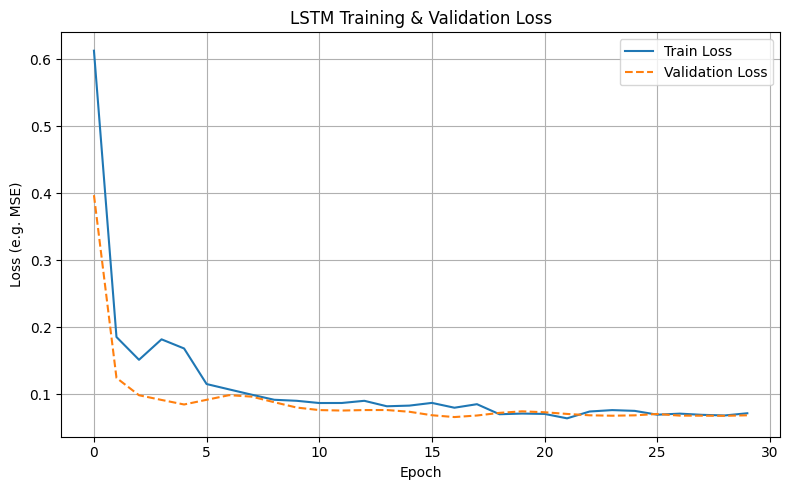

In [11]:
import matplotlib.pyplot as plt

# 画 Loss 曲线
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='--')
plt.title('LSTM Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (e.g. MSE)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


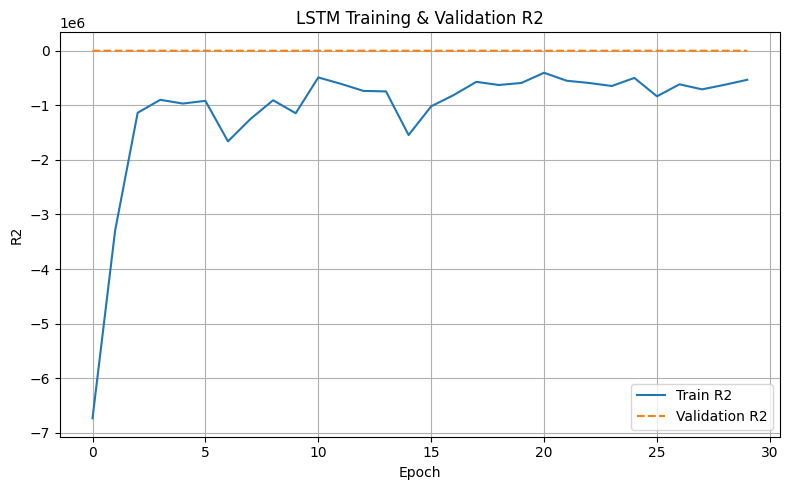

In [12]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['r2_keras'], label='Train R2')
plt.plot(history.history['val_r2_keras'], label='Validation R2', linestyle='--')
plt.title('LSTM Training & Validation R2')
plt.xlabel('Epoch')
plt.ylabel('R2')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step
Train MSE: 2.2511
Train R2: 0.3331


Text(0.5, 1.0, 'Train Prediction vs Ground Truth')

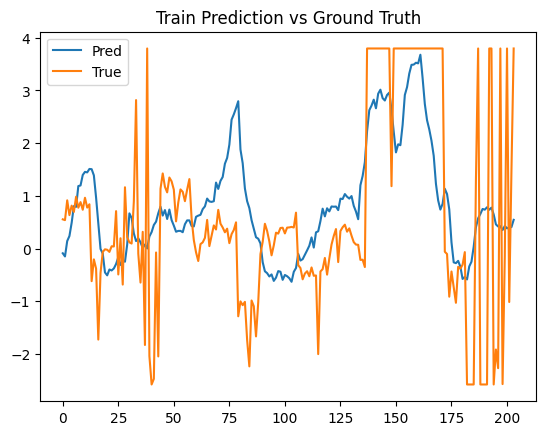

In [13]:
from sklearn.metrics import mean_squared_error, r2_score

y_pred = model.predict(X_train)
y_train_inv = scaler_y.inverse_transform(y_train)
y_pred_inv = scaler_y.inverse_transform(y_pred)

mse = mean_squared_error(y_train_inv, y_pred_inv)
r2 = r2_score(y_train_inv, y_pred_inv)
print(f"Train MSE: {mse:.4f}")
print(f"Train R2: {r2:.4f}")

plt.plot(y_pred_inv, label='Pred')
plt.plot(y_train_inv, label='True')
plt.legend()
plt.title("Train Prediction vs Ground Truth")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Test MSE: 2.7935
Test R2: 0.1901


Text(0.5, 1.0, 'Test Prediction vs Ground Truth')

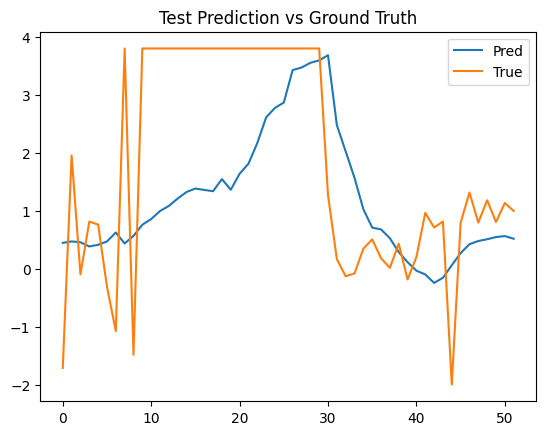

In [14]:
# Predict and evaluate
from sklearn.metrics import mean_squared_error, r2_score

y_pred = model.predict(X_test)
y_test_inv = scaler_y.inverse_transform(y_test)
y_pred_inv = scaler_y.inverse_transform(y_pred)

mse = mean_squared_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)
print(f"Test MSE: {mse:.4f}")
print(f"Test R2: {r2:.4f}")

plt.plot(y_pred_inv, label='Pred')
plt.plot(y_test_inv, label='True')
plt.legend()
plt.title("Test Prediction vs Ground Truth")